In [2]:
import pandas as pd
import numpy as np
import torch
import sys
import pickle
sys.path.insert(0, '../../src/')

In [3]:
graphs = ["RRG", "proximity", "work", "i_bird"]

In [4]:
res = {}
for g in graphs:
    with open(f"./{g}/pos_sources.pkl", "rb") as f:
        res[g]=pickle.load(f)


In [5]:
res[g];

In [6]:
class graph_info:
    def __init__(self,
                N = 100,
                d = 10,
                h = 3,
                a_min = 0.1,
                a_max=0.3,
                a_step=0.1,
                a_show=10,
                nsims=[1_000_000, 10_000_000],
                t_limit=15,
                lambda_=0.02,
                gamma=1e-3,
                mu=0.2,
                small_lambda_limit = 0,
                scale = 2,
                type_graph="RRG",                 
        ):
        self.N = N
        self.a_min = a_min
        self.a_max= a_max
        self.a_step = a_step
        self.nsims = nsims
        self.t_limit = t_limit
        self.lambda_ = lambda_
        self.mu = mu
        self.gamma = gamma
        self.small_lambda_limit = small_lambda_limit
        self.scale = scale
        self.a_show = a_show


In [7]:
infos = {}
g="RRG"
infos[g] = graph_info(
                N = 100,
                d = 10,
                h = 3,
                a_min = 0.1,
                a_max=0.22,
                a_step=0.01,
                a_show= 21,
                nsims = list(res[g]["sm"][0].keys()),
                t_limit=15,
                lambda_=0.02,
                gamma=1e-3,
                mu=0.02,
                small_lambda_limit = 0,
                scale = 2,
                type_graph=g)
g="proximity"
infos[g] = graph_info(
                N = 100,
                d = 10,
                h = 3,
                a_min = 0.01,
                a_max=0.3,
                a_step=0.01,
                a_show= 14,
                nsims = list(res[g]["sm"][0].keys()),
                t_limit=15,
                lambda_=0.03,
                gamma=1e-3,
                mu=0.02,
                small_lambda_limit = 0,
                scale = 2,
                type_graph=g)
g="work"
infos[g] = graph_info(
                N = 95,
                d = 10,
                h = 3,
                a_min = 0.001,
                a_max=0.3,
                a_step=0.02,
                a_show= 8,
                nsims = list(res[g]["sm"][0].keys()),
                t_limit=12,
                lambda_=0.5,
                gamma=1e-3,
                mu=0.02,
                small_lambda_limit = 0,
                scale = 2,
                type_graph=g)
g="i_bird"
infos[g] = graph_info(
                N = 330,
                d = 3,
                h = 3,
                a_min = 0.01,
                a_max=0.22,
                a_step=0.01,
                a_show= 13,
                nsims = list(res[g]["sm"][0].keys()),
                t_limit=14,
                lambda_=0.5,
                gamma=2e-4,
                mu=0.02,
                small_lambda_limit = 300,
                scale = 2,
                type_graph=g)


In [8]:
for i_g, g in enumerate(graphs):
    ann = (res[g]["regressive"] == 0).sum()    
    sib = (res[g]["sib"] == 0).sum()
    sm = (res[g]["sib"] == 0).sum()
    print(f"{g} -- ann: {ann/100:.0%}, sib: {sib/100:.0%}")


RRG -- ann: 18%, sib: 19%
proximity -- ann: 15%, sib: 9%
work -- ann: 20%, sib: 8%
i_bird -- ann: 74%, sib: 52%


In [9]:
import analysis.results_analysis
from sklearn.metrics import auc

In [55]:
import seaborn as sns
from utils.common import pretty_print_n
from sklearn.metrics import auc
def plot_patient_zero_roc(ax1,
                          ax2,
                          pos_sources, 
                          nsims, 
                          args,
                          alpha=5, 
                          bins=10,
                          range_=(0,1),
                          norm=1,
                          colors=None,
                         rnd=False):
    if colors == None:
        colors=plt.get_cmap("Greens")
    num_inst=len(pos_sources["regressive"])
    s_nn,edge = np.histogram(pos_sources["regressive"]/norm, bins=bins, range=range_)
    s_sib,edge = np.histogram(pos_sources["sib"]/norm, bins=bins, range=range_)
    s_rnd,edge = np.histogram(pos_sources["rnd"]/norm, bins=bins, range=range_)
    s_rnd_I,edge = np.histogram(pos_sources["rnd_I"]/norm, bins=bins, range=range_)
    
    ann_zero = (pos_sources["regressive"]==0).sum()/num_inst
    sib_zero = (pos_sources["sib"]==0).sum()/num_inst
    rnd_zero = (pos_sources["rnd"]==0).sum()/num_inst
    rnd_I_zero = (pos_sources["rnd_I"]==0).sum()/num_inst

    #y_nn = np.cumsum(s_nn)/num_inst
    #y_sib= np.cumsum(s_sib)/num_inst
    #y_rnd = np.cumsum(s_rnd)/num_inst
    #y_rnd_I = np.cumsum(s_rnd_I)/num_inst

    y_nn = np.insert(np.cumsum(s_nn)/num_inst,0,ann_zero)
    y_sib= np.insert(np.cumsum(s_sib)/num_inst,0,sib_zero)
    y_rnd = np.insert(np.cumsum(s_rnd)/num_inst,0,rnd_zero)
    y_rnd_I = np.insert(np.cumsum(s_rnd_I)/num_inst,0,rnd_I_zero)

    
    #y_nn = np.insert(y_nn,0,0)
    #y_sib= np.insert(y_sib,0,0)
    #y_rnd = np.insert(y_rnd,0,0)
    #y_rnd_I = np.insert(y_rnd_I,0,0)
    
    x = edge
    #x = np.insert(x,1,1)
    #print(x, y_nn)
    cl=0
    aucs = {}

    if rnd: plt.plot(x, y_rnd, "--", label=f"random -- auc: {auc(x, y_rnd):.3f}", color="black")
    aucs["ANN"] = auc(x, y_nn)
    aucs["SIB"] = auc(x, y_sib)
    ax1.plot(x, y_nn, label=f"ANN -- auc: {auc(x, y_nn):.3f}", linewidth="2")
    ax1.plot(x, y_sib, "-.", label=f"SIB -- auc: {auc(x, y_sib):.3f}", linewidth="2")

    #try:
    aucs["SM"] = 0
    sm_zero_max = 0
    for i, nsim in enumerate(nsims):
        alpha=alpha
        pos_source_sm=[pos_sources["sm"][ii][nsim][alpha] for ii in range(len(pos_sources["sm"]))]
        s_sm,edge = np.histogram(np.array(pos_source_sm)/norm, bins=bins, range=range_)
        sm_zero = (np.array(pos_source_sm)==0).sum()/num_inst
        sm_zero_max = max(sm_zero_max, sm_zero)
        y_sm = np.insert(np.cumsum(s_sm)/num_inst,0,sm_zero)
        y_sm = np.insert(np.cumsum(s_sm)/num_inst,0,sm_zero)
        #y_sm = np.cumsum(s_sm)/num_inst
        aucs["SM"] = max(aucs["SM"], auc(x, y_sm))
        label = f"SM - {args.a_min+alpha*args.a_step:.2f} -- auc {auc(x, y_sm):.3f} -- sims:{nsim:.0e}"
        label = f"SM [{pretty_print_n(nsim)}] -- auc {auc(x, y_sm):.3f}"
        val_col = i/len(nsims) if len(nsims) == 3 else (i+1)/(len(nsims)+1)
        ax1.plot(x, y_sm, ":",
                 label=label, 
                 color=colors(np.clip(val_col, 0.3, 0.9)), lw=2)
    #plt.plot(x, y_rnd_I, "--", label=f"random -- auc: {auc(x, y_rnd_I):.3f} [{rnd_I_zero:.0%}]", color="black")

    #except:
    #    pass
    sns.barplot(y=[ann_zero, sib_zero, sm_zero_max], x=["ANN", "SIB", "SM"], ax=ax2,
    orient="v",
    color=list(sns.color_palette())[3],
    #color="Grey",
    #saturation=0.6
    )
    if ann_zero < 0.5:
        ax2.set_ylim(0,0.25)
        #print("pippo")
    return plt, aucs

/var/folders/jy/gjfds_4d4xsfqkq02klzlj240000gn/T/ipykernel_55511/2622786819.py:58: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


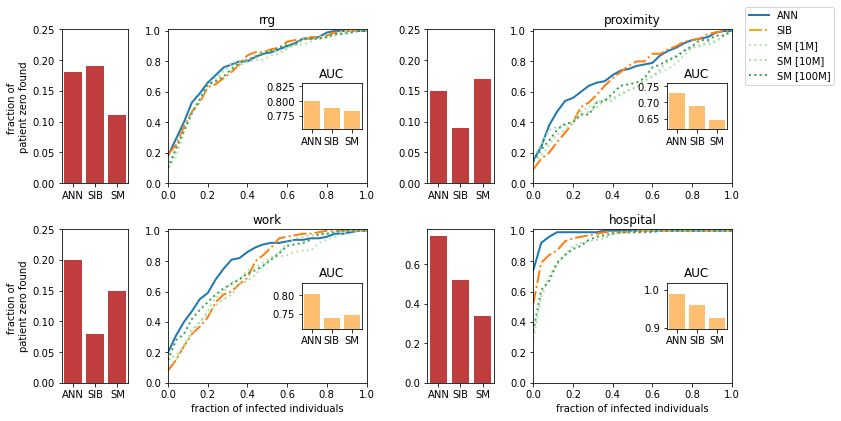

In [56]:

import matplotlib.pyplot as plt
from matplotlib import gridspec
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.lines import Line2D

graph_name=["rrg", "proximity", "work", "hospital"]
fig = plt.figure(figsize=(12, 6.5)) 

gs = gridspec.GridSpec(2, 2, hspace=0.3) 
plt.tight_layout()

for i_g, g in enumerate(graphs):
    #print(int(i_g/2), i_g%2)
    #ax = axs[int(i_g/2)][i_g%2]
    #print(int(i_g/2), 2*(i_g%2))
    #print(int(i_g/2), 2*(i_g%2) + 1)
    out_g = gridspec.GridSpecFromSubplotSpec(1, 2, subplot_spec = gs[int(i_g/2),i_g%2],  width_ratios=[1,3], wspace=0.3)
    ax1 = plt.subplot(out_g[1])
    ax2 = plt.subplot(out_g[0])
    pos_sources = res[g]
    bins=25
    nsims = list(res[g]["sm"][0].keys())
    axs, aucs = plot_patient_zero_roc(ax1, ax2,
                              pos_sources, 
                              infos[g].nsims, 
                              infos[g],
                              alpha=infos[g].a_show, 
                              bins=bins,
                              range_=(0,1),
                              norm=pos_sources["Is_len"],
                              colors=plt.get_cmap("Greens"))
    #ax1.legend()
    ax1.set_xlim(0,1)
    ax1.set_ylim(0,1.01)
    ax1.set_title(f"{graph_name[i_g]}")
    if int(i_g/2):
        ax1.set_xlabel("fraction of infected individuals")
    if not i_g%2:
        ax2.set_ylabel("fraction of \npatient zero found")
    #plt.ylim(0,17)
    axins2 = inset_axes(ax1, width="30%", height="30%", loc=5)
    sns.barplot(y=list(aucs.values()), x=list(aucs.keys()), ax=axins2,
    orient="v",
    color=list(sns.color_palette())[6],
    saturation=1)
    axins2.set_ylim(min(list(aucs.values())) - 0.03, max(list(aucs.values())) + 0.03)
    axins2.set_title("AUC")
    #axins2.set_xticklabels([])

colors=plt.get_cmap("Greens")
legend_elements = [Line2D([0], [0], lw=2, label='ANN'),
                    Line2D([0], [0], linestyle="-.", lw=2, label='SIB', color="orange"),
                    Line2D([0], [0], linestyle=":", lw=2, label='SM [1M]', color=colors(np.clip(0., 0.3, 0.9))),
                    Line2D([0], [0], linestyle=":", lw=2, label='SM [10M]', color=colors(np.clip(0.33, 0.3, 0.9))),
                    Line2D([0], [0], linestyle=":", lw=2, label='SM [100M]', color=colors(np.clip(0.66, 0.3, 0.9))),]

plt.legend(handles=legend_elements, loc=(1.3,5.3))
plt.tight_layout()

plt.savefig("img/pz.pdf", bbox_inches="tight",dpi=100)
plt.show()

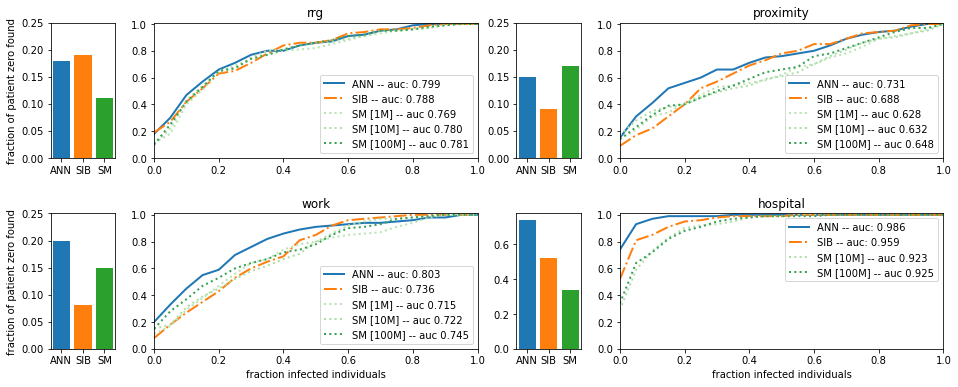

In [11]:
import matplotlib.pyplot as plt
from matplotlib import gridspec

graph_name=["rrg", "proximity", "work", "hospital"]
fig = plt.figure(figsize=(16, 6)) 

gs = gridspec.GridSpec(2, 4, width_ratios=[1,5,1,5], hspace=0.41) 
plt.tight_layout()

for i_g, g in enumerate(graphs):
    #print(int(i_g/2), i_g%2)
    #ax = axs[int(i_g/2)][i_g%2]
    #print(int(i_g/2), 2*(i_g%2))
    #print(int(i_g/2), 2*(i_g%2) + 1)
    ax1 = plt.subplot(gs[int(i_g/2),  2*(i_g%2)+1])
    ax2 = plt.subplot(gs[int(i_g/2),  2*(i_g%2)])

    pos_sources = res[g]
    bins=20
    nsims = list(res[g]["sm"][0].keys())
    axs = plot_patient_zero_roc(ax1, ax2,
                              pos_sources, 
                              infos[g].nsims, 
                              infos[g],
                              alpha=infos[g].a_show, 
                              bins=bins,
                              range_=(0,1),
                              norm=pos_sources["Is_len"],
                              colors=plt.get_cmap("Greens"))
    ax1.legend()
    ax1.set_xlim(0,1)
    ax1.set_ylim(0,1.01)
    ax1.set_title(f"{graph_name[i_g]}")
    if int(i_g/2):
        ax1.set_xlabel("fraction infected individuals")
    if not i_g%2:
        ax2.set_ylabel("fraction of patient zero found")
    #plt.ylim(0,17)
#plt.savefig("img/pz.pdf")
plt.show()

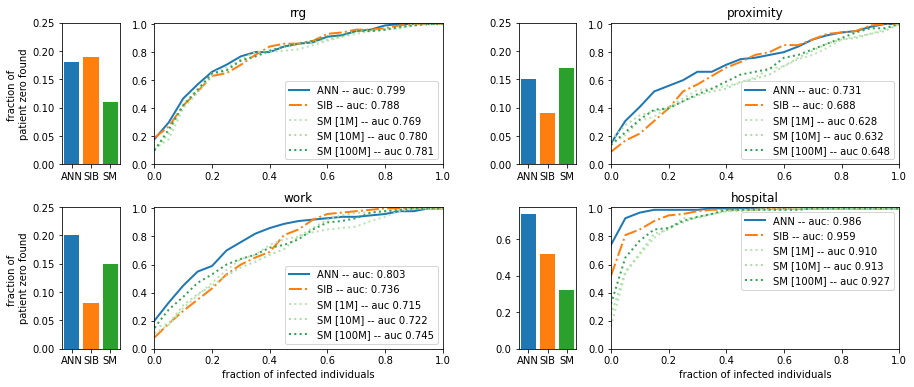

In [11]:

import matplotlib.pyplot as plt
from matplotlib import gridspec

graph_name=["rrg", "proximity", "work", "hospital"]
fig = plt.figure(figsize=(15, 6)) 

gs = gridspec.GridSpec(2, 2, hspace=0.3) 
plt.tight_layout()

for i_g, g in enumerate(graphs):
    #print(int(i_g/2), i_g%2)
    #ax = axs[int(i_g/2)][i_g%2]
    #print(int(i_g/2), 2*(i_g%2))
    #print(int(i_g/2), 2*(i_g%2) + 1)
    out_g = gridspec.GridSpecFromSubplotSpec(1, 2, subplot_spec = gs[int(i_g/2),i_g%2],  width_ratios=[1,5])
    ax1 = plt.subplot(out_g[1])
    ax2 = plt.subplot(out_g[0])
    pos_sources = res[g]
    bins=20
    nsims = list(res[g]["sm"][0].keys())
    axs, aucs = plot_patient_zero_roc(ax1, ax2,
                              pos_sources, 
                              infos[g].nsims, 
                              infos[g],
                              alpha=infos[g].a_show, 
                              bins=bins,
                              range_=(0,1),
                              norm=pos_sources["Is_len"],
                              colors=plt.get_cmap("Greens"))
    ax1.legend()
    ax1.set_xlim(0,1)
    ax1.set_ylim(0,1.01)
    ax1.set_title(f"{graph_name[i_g]}")
    if int(i_g/2):
        ax1.set_xlabel("fraction of infected individuals")
    if not i_g%2:
        ax2.set_ylabel("fraction of \npatient zero found")
    #plt.ylim(0,17)
plt.savefig("img/pz.pdf", bbox_inches="tight")
plt.show()

<ipython-input-17-d83e49886a9d>:58: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


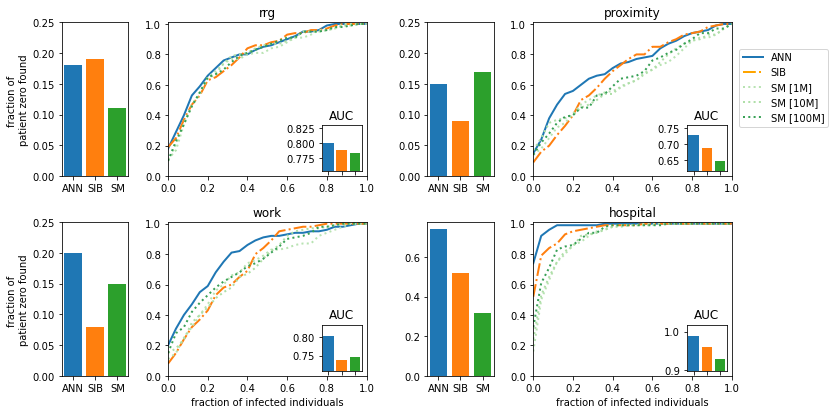

In [17]:

import matplotlib.pyplot as plt
from matplotlib import gridspec
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.lines import Line2D

graph_name=["rrg", "proximity", "work", "hospital"]
fig = plt.figure(figsize=(12, 6.5)) 

gs = gridspec.GridSpec(2, 2, hspace=0.3) 
plt.tight_layout()

for i_g, g in enumerate(graphs):
    #print(int(i_g/2), i_g%2)
    #ax = axs[int(i_g/2)][i_g%2]
    #print(int(i_g/2), 2*(i_g%2))
    #print(int(i_g/2), 2*(i_g%2) + 1)
    out_g = gridspec.GridSpecFromSubplotSpec(1, 2, subplot_spec = gs[int(i_g/2),i_g%2],  width_ratios=[1,3], wspace=0.3)
    ax1 = plt.subplot(out_g[1])
    ax2 = plt.subplot(out_g[0])
    pos_sources = res[g]
    bins=25
    nsims = list(res[g]["sm"][0].keys())
    axs, aucs = plot_patient_zero_roc(ax1, ax2,
                              pos_sources, 
                              infos[g].nsims, 
                              infos[g],
                              alpha=infos[g].a_show, 
                              bins=bins,
                              range_=(0,1),
                              norm=pos_sources["Is_len"],
                              colors=plt.get_cmap("Greens"))
    #ax1.legend()
    ax1.set_xlim(0,1)
    ax1.set_ylim(0,1.01)
    ax1.set_title(f"{graph_name[i_g]}")
    if int(i_g/2):
        ax1.set_xlabel("fraction of infected individuals")
    if not i_g%2:
        ax2.set_ylabel("fraction of \npatient zero found")
    #plt.ylim(0,17)
    axins2 = inset_axes(ax1, width="20%", height="30%", loc=4)
    sns.barplot(y=list(aucs.values()), x=list(aucs.keys()), ax=axins2,
    orient="v",
    palette="tab10",
    saturation=1)
    axins2.set_ylim(min(list(aucs.values())) - 0.03, max(list(aucs.values())) + 0.03)
    axins2.set_title("AUC")
    axins2.set_xticklabels([])

colors=plt.get_cmap("Greens")
legend_elements = [Line2D([0], [0], lw=2, label='ANN'),
                    Line2D([0], [0], linestyle="-.", lw=2, label='SIB', color="orange"),
                    Line2D([0], [0], linestyle=":", lw=2, label='SM [1M]', color=colors(np.clip(0., 0.3, 0.9))),
                    Line2D([0], [0], linestyle=":", lw=2, label='SM [10M]', color=colors(np.clip(0.33, 0.3, 0.9))),
                    Line2D([0], [0], linestyle=":", lw=2, label='SM [100M]', color=colors(np.clip(0.66, 0.3, 0.9))),]

plt.legend(handles=legend_elements, loc=(1.3,5.3))
plt.tight_layout()

plt.savefig("img/pz.pdf", bbox_inches="tight",dpi=100)
plt.show()

In [1]:

import matplotlib.pyplot as plt
from matplotlib import gridspec
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.lines import Line2D

graph_name=["rrg", "proximity", "work", "hospital"]
fig = plt.figure(figsize=(12, 6.5)) 

gs = gridspec.GridSpec(2, 2, hspace=0.3) 
plt.tight_layout()

for i_g, g in enumerate(graphs):
    #print(int(i_g/2), i_g%2)
    #ax = axs[int(i_g/2)][i_g%2]
    #print(int(i_g/2), 2*(i_g%2))
    #print(int(i_g/2), 2*(i_g%2) + 1)
    out_g = gridspec.GridSpecFromSubplotSpec(1, 2, subplot_spec = gs[int(i_g/2),i_g%2],  width_ratios=[1,3], wspace=0.3)
    ax1 = plt.subplot(out_g[1])
    ax2 = plt.subplot(out_g[0])
    pos_sources = res[g]
    bins=25
    nsims = list(res[g]["sm"][0].keys())
    axs, aucs = plot_patient_zero_roc(ax1, ax2,
                              pos_sources, 
                              infos[g].nsims, 
                              infos[g],
                              alpha=infos[g].a_show, 
                              bins=bins,
                              range_=(0,1),
                              norm=pos_sources["Is_len"],
                              colors=plt.get_cmap("Greens"))
    #ax1.legend()
    ax1.set_xlim(0,1)
    ax1.set_ylim(0,1.01)
    ax1.set_title(f"{graph_name[i_g]}")
    if int(i_g/2):
        ax1.set_xlabel("fraction of infected individuals")
    if not i_g%2:
        ax2.set_ylabel("fraction of \npatient zero found")
    #plt.ylim(0,17)
    axins2 = inset_axes(ax1, width="20%", height="30%", loc=4)
    sns.barplot(y=list(aucs.values()), x=list(aucs.keys()), ax=axins2,
    orient="v",
    palette="tab10",
    saturation=1)
    axins2.set_ylim(min(list(aucs.values())) - 0.03, max(list(aucs.values())) + 0.03)
    axins2.set_title("AUC")
    axins2.set_xticklabels([])

colors=plt.get_cmap("Greens")
legend_elements = [Line2D([0], [0], lw=2, label='ANN'),
                    Line2D([0], [0], linestyle="-.", lw=2, label='SIB', color="orange"),
                    Line2D([0], [0], linestyle=":", lw=2, label='SM [1M]', color=colors(np.clip(0., 0.3, 0.9))),
                    Line2D([0], [0], linestyle=":", lw=2, label='SM [10M]', color=colors(np.clip(0.33, 0.3, 0.9))),
                    Line2D([0], [0], linestyle=":", lw=2, label='SM [100M]', color=colors(np.clip(0.66, 0.3, 0.9))),]

plt.legend(handles=legend_elements, loc=(1.3,5.3))
plt.tight_layout()

plt.savefig("img/pz.pdf", bbox_inches="tight",dpi=100)
plt.show()

NameError: name 'graphs' is not defined

<Figure size 864x468 with 0 Axes>